### Completely Pytorch Native

In [69]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import math
from tqdm import tqdm
%matplotlib inline

In [5]:
words = open('./names.txt').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [6]:
chars = sorted(list(set(''.join(words)))) #lol
token_lookup = {c: i+1 for i, c in enumerate(chars)}
token_lookup['.'] = 0
char_lookup = {i:c for c, i in token_lookup.items()}
TOTAL_TOKENS = len(char_lookup.keys())

In [89]:
# build the dataset

BLOCK_SIZE = 3 # context size to give the model in order to predict the next character

def build_dataset(corpus, block_size, codebook, padding_char="."):
    X, Y = [], []
    for word in corpus:
        start_padding = padding_char * block_size
        padded_word = f"{start_padding}{word}."
        tokenized_word = [codebook[c] for c in padded_word]
        for i in range(len(tokenized_word)-block_size):
            X.append(tokenized_word[i:i+block_size])
            Y.append(tokenized_word[i+block_size])
        
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y


random.shuffle(words)

n1 = int(len(words)*0.8)
n2 = int(len(words)*0.9)

x_train, y_train = build_dataset(words[:n1], BLOCK_SIZE, token_lookup)
x_valid, y_valid = build_dataset(words[n1:n2], BLOCK_SIZE, token_lookup)
x_test, y_test = build_dataset(words[n2:], BLOCK_SIZE, token_lookup)

In [40]:
class MLPBlock(nn.Module):
    
    def __init__(self, in_dims, out_dims):
        
        super(MLPBlock, self).__init__()
        
        self.sequence = nn.Sequential(
            nn.Linear(in_dims, out_dims, bias=False),
            nn.BatchNorm1d(out_dims),
            nn.Tanh()
        )
        
    def forward(self, x):
        self.out = self.sequence(x)
        return self.out

class Reshape(nn.Module):
    
    def __init__(self, target_shape):
        super(Reshape, self).__init__()
        self.target_shape = target_shape
        
    def forward(self, x):
        return x.view(self.target_shape)

class Model(nn.Module):
    
    def __init__(self, token_size:int, embedding_dims:int, hidden_dims:int, block_size:int):
        
        super(Model, self).__init__()
        
        self.sequence = nn.Sequential(
            nn.Embedding(token_size, embedding_dims),
            Reshape((-1, embedding_dims * block_size)),
            MLPBlock(embedding_dims * block_size, hidden_dims),
            MLPBlock(hidden_dims, hidden_dims),
            MLPBlock(hidden_dims, hidden_dims),
            MLPBlock(hidden_dims, hidden_dims),
            MLPBlock(hidden_dims, hidden_dims),
            nn.Linear(hidden_dims, token_size)
        )
        
    def forward(self, x):
        self.out = self.sequence(x)
        return self.out

In [84]:
model = Model(embedding_dims=10, token_size=TOTAL_TOKENS, hidden_dims=200, block_size=3)

device = 'cuda:1'
steps = 25000
print_steps = 2000
BATCH_SIZE = 256

model.to(device)
losses = []

optim = torch.optim.Adam(model.parameters())
scheduler = torch.scheduler.
pbar = tqdm(range(steps))

for t in pbar:
    batch_ix = torch.randint(0, x_train.shape[0], (BATCH_SIZE,))
    batch = x_train[batch_ix].to(device)
    logits = model(batch)
    
    loss = F.cross_entropy(logits, y_train[batch_ix].to(device))
    losses.append(loss.item())
    pbar.set_description(desc=f'average loss: {(sum(losses[-100:])/100):.2f}')

    model.zero_grad()
    loss.backward()
    optim.step()

average loss: 1.96: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [01:25<00:00, 292.13it/s]


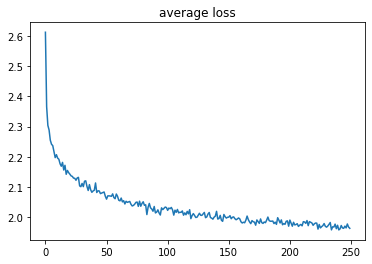

In [85]:
plt.plot(torch.tensor(losses).view(-1, 100).mean(1))
plt.title("average loss");

In [86]:
model.train(False)

# clculate training and validation loss
@torch.no_grad()
def calc_loss(x_target, y_target):
    logits = model(x_target.to(device))
    loss = F.cross_entropy(logits, y_target.to(device))
    return loss

calc_loss(x_train, y_train), calc_loss(x_valid, y_valid)

(tensor(1.9625, device='cuda:1'), tensor(2.0989, device='cuda:1'))

In [87]:
# sample
@torch.no_grad()
def sample():
    tokens = [0] * BLOCK_SIZE
    while True:
        cur_tokens = torch.tensor(tokens[-BLOCK_SIZE:]).to(device)
        logits = model(cur_tokens)
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        tokens.append(ix)
        if ix == 0:
            break
    return "".join([char_lookup[t] for t in tokens][BLOCK_SIZE:-1])

for i in range(20):
    print(sample())

shawaa
kameel
cora
doe
maidalyn
kaymoni
reeson
livy
tashvi
sir
zyaislia
kace
aryleah
kol
mani
kata
julla
dagiana
bire
oniyla
